## Michael Beven - 455613
## University of Chicago - Financial Mathematics
## FINM 33150 - Quantitative Strategies and Regression
## Homework 6

===================================

**In this assignment we investigate the performances of OLS, Huber and Tukey regression methods.  The latter two are robust regressions, therefore we expect them to work better if assumptions (such as gaussian data) break down.  By observing across a large number of regressions for equities (where SPY is the independent variable), we hope to get an overall idea for performances.**


**First we set up our notebook:**

In [1]:
#~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*#
# Michael Hyeong-Seok Beven              #
# University of Chicago                  #
# Financial Mathematics                  #
# Quantitative Strategies and Regression #
# Homework 6                             #
#~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*#

##########################
# ipython notebook setup #
##########################

from statsmodels.regression.linear_model import OLS
from statsmodels.robust.robust_linear_model import RLM # Huber, Tukey
import statsmodels.api as sm
import pandas as pd
import numpy as np
import Quandl
import keyring as kr # hidden password
key = kr.get_password('Quandl','mbeven')
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.chdir('/Users/michaelbeven/Documents/06_School/2016 Spring/FINM_2016_SPRING/FINM 33150/HW6')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 82)
pd.set_option('precision', 6)

**Next we set up the start and end dates of analysis:**

In [2]:
##############
# parameters #
##############

start_date = '2016-01-01'
end_date = '2016-02-29'

**Now we have to obtain the data.  The first time, the data is taken from Quandl online.  We then store the data somewhere so it does not have to be downloaded each time.  Stocks from the EOD data set on Quandl are used, where there is no missing data in the dates of analysis:**

In [ ]:
########
# data #
########

#intial grab
codes = pd.read_csv('EOD-datasets-codes.csv',names=['code','desc']).code
count = 0 # count for non empty data sets
data = {}
codes_final = []
for i in range(0,len(codes)):
    data[codes[i]] = Quandl.get(codes[i],authtoken=key,trim_start=start_date,trim_end=end_date,returns="pandas").Adj_Close
    if len(data[codes[i]]) != 39:
        del data[codes[i]]
        continue
    data[codes[i]].to_csv('Data/' + codes[i].replace('/','') + '.csv')
    count = count + 1
    codes_final.append(codes[i])
    if count == 600:
        break
print('The number of non-empty data sets is {}'.format(count))
pd.DataFrame(codes_final).to_csv('Data/codes_final.csv')

**The SPY data is to be obtained separately:**

In [3]:
#SPY data
P_SPY = pd.DataFrame(Quandl.get('EOD/SPY',authtoken=key,trim_start=start_date,trim_end=end_date,returns="pandas").Adj_Close)

**The following code reads in the already downloaded data:**

In [4]:
#grab saved csv files
codes_final = pd.read_csv('Data/codes_final.csv').ix[:,1]

data = {}
for i in range(0,len(codes_final)):
    data[codes_final[i]] = pd.read_csv('Data/' + codes_final[i].replace('/','') + '.csv',names=['Adj_Close']).ix[:,0]
    data[codes_final[i]] = pd.DataFrame(data[codes_final[i]]).set_index(P_SPY.index)

**Now we begin to manipulate the data in order to do analysis.  First generate returns.  I have assumed log returns:**

In [5]:
############
# analysis #
############

# turn into returns
rets = {}
for key in data:
    P = data[key]
    R = np.log(P) - np.log(P.shift(1))
    rets[key] = R

R_SPY = np.log(P_SPY) - np.log(P_SPY.shift(1))

**Next, run the assignment regressions for both a fixed and non-fixed origin.  An intercept is added by using ```sm.add_constant()```:**

In [6]:
# run regressions
OLS_A = {}
OLS_B = {}
Huber_A = {}
Huber_B = {}
Tukey_A = {}
Tukey_B = {}
for key in rets:
    OLS_A[key] = OLS(rets[key][1:21],R_SPY[1:21],missing='drop').fit()
    OLS_B[key] = OLS(rets[key][1:21],sm.add_constant(R_SPY[1:21]),missing='drop').fit()
    Huber_A[key] = RLM(rets[key][1:21],R_SPY[1:21],missing='drop',M=sm.robust.norms.HuberT()).fit()
    Huber_B[key] = RLM(rets[key][1:21],sm.add_constant(R_SPY[1:21]),missing='drop',M=sm.robust.norms.HuberT()).fit()
    Tukey_A[key] = RLM(rets[key][1:21],R_SPY[1:21],missing='drop',M=sm.robust.norms.TukeyBiweight()).fit()
    Tukey_B[key] = RLM(rets[key][1:21],sm.add_constant(R_SPY[1:21]),missing='drop',M=sm.robust.norms.TukeyBiweight()).fit()

**We can now now calculate the out of sample residuals by taking the difference between out of sample returns and the fitted lines from above:**

In [26]:
# residuals
resid_OLS_A = {}
resid_OLS_B = {}
resid_Huber_A = {}
resid_Huber_B = {}
resid_Tukey_A = {}
resid_Tukey_B = {}
for key in rets:
    resid_OLS_A[key] = rets[key][22:28] - R_SPY[22:28]*OLS_A[key].params[0]
    resid_OLS_B[key] = rets[key][22:28] - (R_SPY[22:28]*OLS_B[key].params[1] + OLS_B[key].params[0])
    resid_Huber_A[key] = rets[key][22:28] - R_SPY[22:28]*Huber_A[key].params[0]
    resid_Huber_B[key] = rets[key][22:28] - (R_SPY[22:28]*Huber_B[key].params[1] + Huber_B[key].params[0])
    resid_Tukey_A[key] = rets[key][22:28] - R_SPY[22:28]*Tukey_A[key].params[0]
    resid_Tukey_B[key] = rets[key][22:28] - (R_SPY[22:28]*Tukey_B[key].params[1] + Tukey_B[key].params[0])

**We can also calculate the in sample residual standard deviation for each:**

In [27]:
# in-sample volatility
Vol_OLS_A = {}
Vol_OLS_B = {}
Vol_Huber_A = {}
Vol_Huber_B = {}
Vol_Tukey_A = {}
Vol_Tukey_B = {}
for key in rets:
    Vol_OLS_A[key] = OLS_A[key].resid.std()
    Vol_OLS_B[key] = OLS_B[key].resid.std()
    Vol_Huber_A[key] = Huber_A[key].resid.std()
    Vol_Huber_B[key] = Huber_B[key].resid.std()
    Vol_Tukey_A[key] = Tukey_A[key].resid.std()
    Vol_Tukey_B[key] = Tukey_B[key].resid.std()

**First let's look at performance based on the non-normalized residuals:**

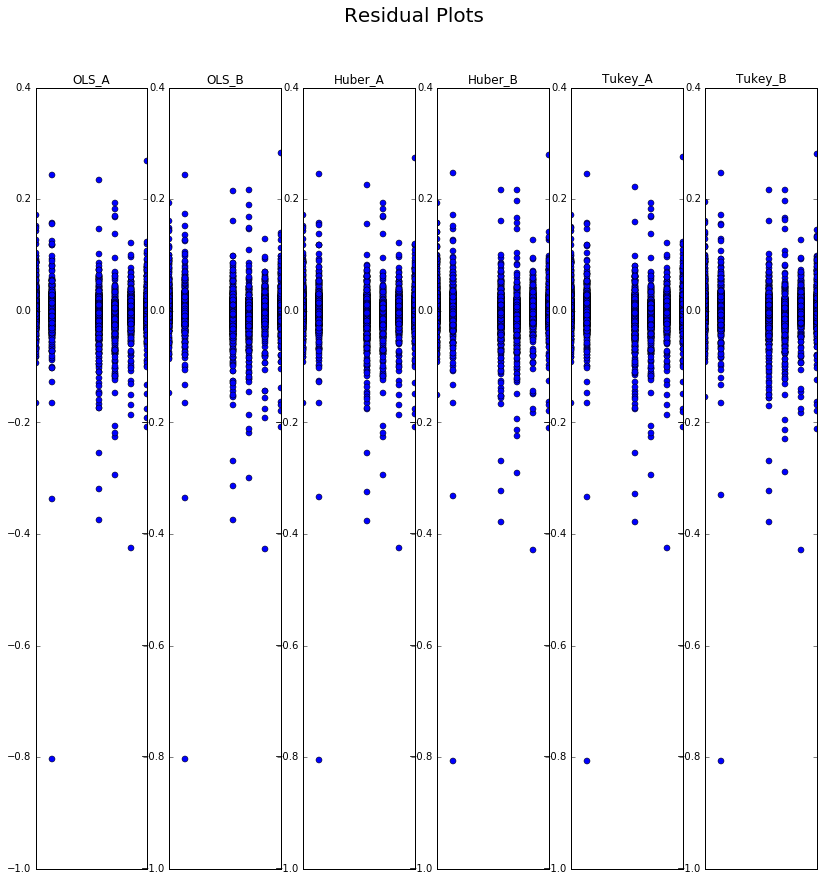

In [28]:
#################
# performance 1 #
#################

resids_OLS_A = pd.DataFrame()
resids_OLS_B = pd.DataFrame()
resids_Huber_A = pd.DataFrame()
resids_Huber_B = pd.DataFrame()
resids_Tukey_A = pd.DataFrame()
resids_Tukey_B = pd.DataFrame()
for key in rets:
    resids_OLS_A = pd.concat((resids_OLS_A,pd.DataFrame(resid_OLS_A[key])),axis=0)
    resids_OLS_B = pd.concat((resids_OLS_B,pd.DataFrame(resid_OLS_B[key])),axis=0)
    resids_Huber_A = pd.concat((resids_Huber_A,pd.DataFrame(resid_Huber_A[key])),axis=0)
    resids_Huber_B = pd.concat((resids_Huber_B,pd.DataFrame(resid_Huber_B[key])),axis=0)
    resids_Tukey_A = pd.concat((resids_Tukey_A,pd.DataFrame(resid_Tukey_A[key])),axis=0)
    resids_Tukey_B = pd.concat((resids_Tukey_B,pd.DataFrame(resid_Tukey_B[key])),axis=0)

#resids plot
plt.figure(figsize=(14,14))
plt.suptitle('Residual Plots',fontsize=20)
x1 = plt.subplot(161)
plt.title('OLS_A')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_OLS_A.index,resids_OLS_A,'o')
x1 = plt.subplot(162)
plt.title('OLS_B')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_OLS_B.index,resids_OLS_B,'o')
plt.xlabel('')
x1 = plt.subplot(163)
plt.title('Huber_A')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_Huber_A.index,resids_Huber_A,'o')
plt.xlabel('')
x1 = plt.subplot(164)
plt.title('Huber_B')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_Huber_B.index,resids_Huber_B,'o')
plt.xlabel('')
x1 = plt.subplot(165)
plt.title('Tukey_A')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_Tukey_A.index,resids_Tukey_A,'o')
plt.xlabel('')
x1 = plt.subplot(166)
plt.title('Tukey_B')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_Tukey_B.index,resids_Tukey_B,'o')
plt.xlabel('')

**Above are plots of the residual amounts over the 6 out of sample days for each model.  Points that are further from the mean generally look the same.  This means that outliers will be similar across models.  It is hard to tell from this plot however if points in the denser areas are behaving differently.  To better inspect this, we can look at histograms of each model:**

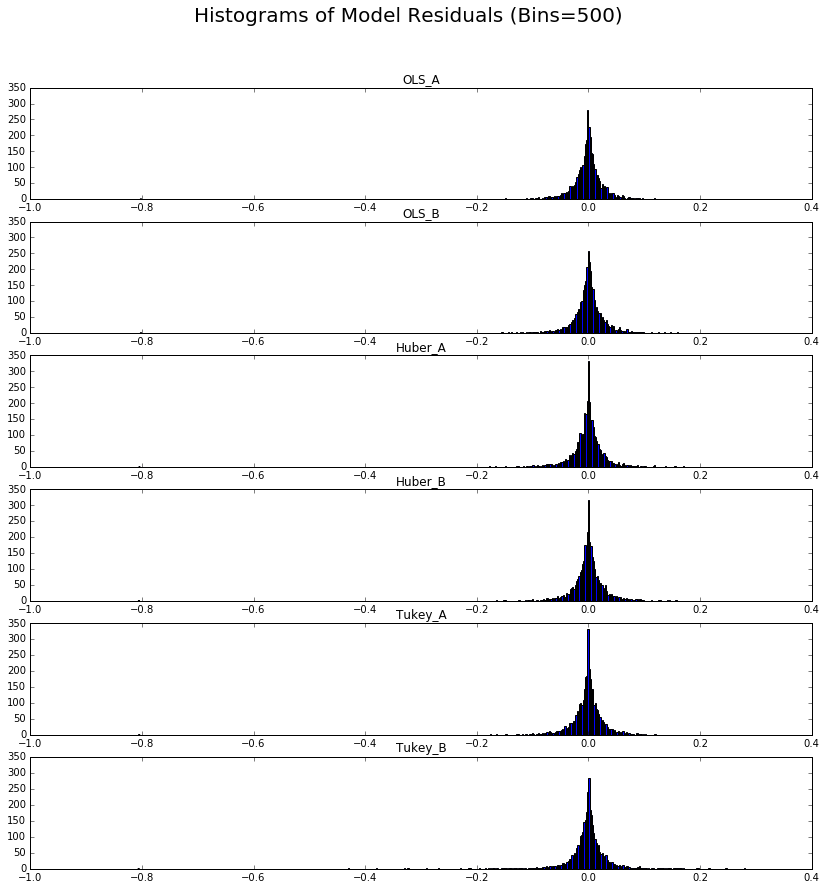

In [29]:
#histograms
plt.figure(figsize=(14,14))
plt.suptitle('Histograms of Model Residuals (Bins=500)',fontsize=20)
x1 = plt.subplot(611)
x1.set_ylim([0,350])
plt.title('OLS_A')
hist1 = plt.hist(np.array(resids_OLS_A),500)
x1 = plt.subplot(612)
x1.set_ylim([0,350])
plt.title('OLS_B')
hist2 = plt.hist(np.array(resids_OLS_B),500)
x1 = plt.subplot(613)
x1.set_ylim([0,350])
plt.title('Huber_A')
hist3 = plt.hist(np.array(resids_Huber_A),500)
x1 = plt.subplot(614)
x1.set_ylim([0,350])
plt.title('Huber_B')
hist4 = plt.hist(np.array(resids_Huber_B),500)
x1 = plt.subplot(615)
x1.set_ylim([0,350])
plt.title('Tukey_A')
hist5 = plt.hist(np.array(resids_Tukey_A),500)
x1 = plt.subplot(616)
x1.set_ylim([0,350])
plt.title('Tukey_B')
hist6 = plt.hist(np.array(resids_Tukey_B),500)
plt.show()

**These plots above suggest that the robust regressions are slightly more heavy tailed, however this should be judged with a grain of salt.  Quantile plots between the models only reveal straight 45 degree lines, which would suggest the distribution of residuals is the same between models.  We can also look at some aggregate statistics:**

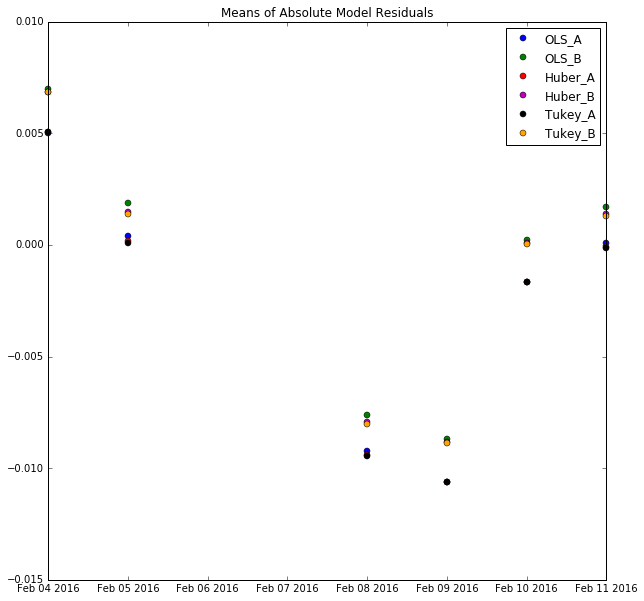

In [30]:
#means by day
means_OLS_A = resids_OLS_A.groupby(resids_OLS_A.index).mean()
means_OLS_B = resids_OLS_B.groupby(resids_OLS_B.index).mean()
means_Huber_A = resids_Huber_A.groupby(resids_Huber_A.index).mean()
means_Huber_B = resids_Huber_B.groupby(resids_Huber_B.index).mean()
means_Tukey_A = resids_Tukey_A.groupby(resids_Tukey_A.index).mean()
means_Tukey_B = resids_Tukey_B.groupby(resids_Tukey_B.index).mean()
plt.figure(figsize=(10,10))
plt.plot(means_OLS_A.index,means_OLS_A,'o',clip_on=False)
plt.plot(means_OLS_B.index,means_OLS_B,'go',clip_on=False)
plt.plot(means_Huber_A.index,means_Huber_A,'ro',clip_on=False)
plt.plot(means_Huber_B.index,means_Huber_B,'mo',clip_on=False)
plt.plot(means_Tukey_A.index,means_Tukey_A,'o',color='black',clip_on=False)
plt.plot(means_Tukey_B.index,means_Tukey_B,'o',color='orange',clip_on=False)
plt.title('Means of Absolute Model Residuals')
plt.legend(['OLS_A','OLS_B','Huber_A','Huber_B','Tukey_A','Tukey_B'],loc='best',numpoints=1)
plt.show()

**One might expect that over time the quality of the model prediction would decrease, however the means of residuals do no seem to change much over time.  Six days is also a small time frame to judge this - perhaps looking at a longer horizon of out of sample residuals would help make a stronger conclusion.  Also note that mean residuals are grouped for the models, suggesting little difference between the method of regression used, as well as indifference of fitting with or without an intercept.  We can also look at the standard deviations of residuals:**

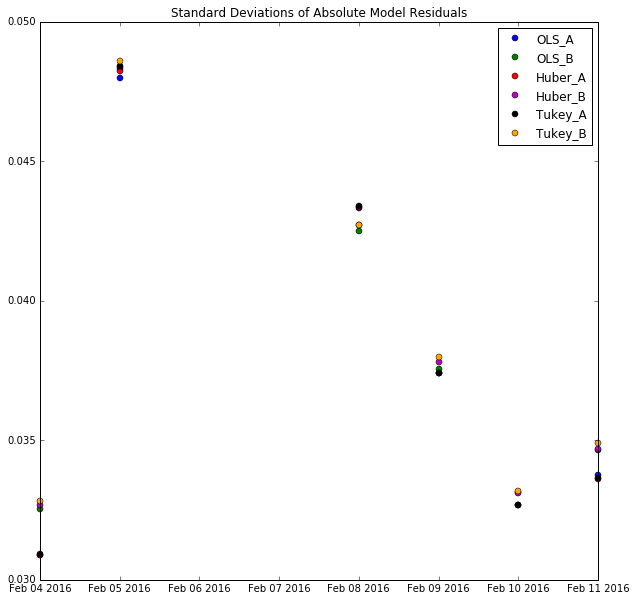

In [31]:
#stdev by day
std_OLS_A = resids_OLS_A.groupby(resids_OLS_A.index).std()
std_OLS_B = resids_OLS_B.groupby(resids_OLS_B.index).std()
std_Huber_A = resids_Huber_A.groupby(resids_Huber_A.index).std()
std_Huber_B = resids_Huber_B.groupby(resids_Huber_B.index).std()
std_Tukey_A = resids_Tukey_A.groupby(resids_Tukey_A.index).std()
std_Tukey_B = resids_Tukey_B.groupby(resids_Tukey_B.index).std()
plt.figure(figsize=(10,10))
plt.plot(means_OLS_A.index,std_OLS_A,'o',clip_on=False)
plt.plot(means_OLS_B.index,std_OLS_B,'go',clip_on=False)
plt.plot(means_Huber_A.index,std_Huber_A,'ro',clip_on=False)
plt.plot(means_Huber_B.index,std_Huber_B,'mo',clip_on=False)
plt.plot(means_Tukey_A.index,std_Tukey_A,'o',color='black',clip_on=False)
plt.plot(means_Tukey_B.index,std_Tukey_B,'o',color='orange',clip_on=False)
plt.title('Standard Deviations of Absolute Model Residuals')
plt.legend(['OLS_A','OLS_B','Huber_A','Huber_B','Tukey_A','Tukey_B'],loc='best',numpoints=1)
plt.show()

**The standard deviations of residuals for each day appear to be downward sloping, however again we probably are not using enough data.  Results are again bunched for different models, which suggests the regressions produce similar results in the first two moments.**

In [32]:
#overall t stat
t_OLS_A = resids_OLS_A.mean()[0]/resids_OLS_A.std()[0]
t_OLS_B = resids_OLS_B.mean()[0]/resids_OLS_B.std()[0]
t_Huber_A = resids_Huber_A.mean()[0]/resids_Huber_A.std()[0]
t_Huber_B = resids_Huber_B.mean()[0]/resids_Huber_B.std()[0]
t_Tukey_A = resids_Tukey_A.mean()[0]/resids_Tukey_A.std()[0]
t_Tukey_B = resids_Tukey_B.mean()[0]/resids_Tukey_B.std()[0]
print('t-stat of OLS_A: {}'.format(t_OLS_A))
print('t-stat of OLS_B: {}'.format(t_OLS_B))
print('t-stat of Huber_A: {}'.format(t_Huber_A))
print('t-stat of Huber_B: {}'.format(t_Huber_B))
print('t-stat of Tukey_A: {}'.format(t_Tukey_A))
print('t-stat of Tukey_B: {}'.format(t_Tukey_B))

t-stat of OLS_A: -0.06888519694878954
t-stat of OLS_B: -0.02363876790551359
t-stat of Huber_A: -0.07140341633445663
t-stat of Huber_B: -0.0296390263386281
t-stat of Tukey_A: -0.07233477216209504
t-stat of Tukey_B: -0.03096821221757016


**t-tests also show that no model is significantly different from zero at the 95% confidence level.  It is noteable though that the ```A``` models with zero intercept have means which are "more" significantly far from zero than the ```B``` models.  This makes sense, because by forcing a zero intercept, we are taking away a degree of freedom from the model.**

In [33]:
#extreme data
abs(resids_OLS_A).max()
abs(resids_OLS_B).max()
abs(resids_Huber_A).max()
abs(resids_Huber_B).max()
abs(resids_Tukey_A).max()
abs(resids_Tukey_B).max()
print('Largest Absolute Residual of OLS_A: {}'.format((abs(resids_OLS_A).max()[0]-resids_OLS_A.mean()[0])/resids_OLS_A.std()[0]))
print('Largest Absolute Residual of OLS_B: {}'.format((abs(resids_OLS_B).max()[0]-resids_OLS_B.mean()[0])/resids_OLS_B.std()[0]))
print('Largest Absolute Residual of Huber_A: {}'.format((abs(resids_Huber_A).max()[0]-resids_Huber_A.mean()[0])/resids_Huber_A.std()[0]))
print('Largest Absolute Residual of Huber_B: {}'.format((abs(resids_Huber_B).max()[0]-resids_Huber_B.mean()[0])/resids_Huber_B.std()[0]))
print('Largest Absolute Residual of Tukey_A: {}'.format((abs(resids_Tukey_A).max()[0]-resids_Tukey_A.mean()[0])/resids_Tukey_A.std()[0]))
print('Largest Absolute Residual of Tukey_B: {}'.format((abs(resids_Tukey_B).max()[0]-resids_Tukey_B.mean()[0])/resids_Tukey_B.std()[0]))

Largest Absolute Residual of OLS_A: 20.89648445799117
Largest Absolute Residual of OLS_B: 20.66074657749079
Largest Absolute Residual of Huber_A: 20.953266937773446
Largest Absolute Residual of Huber_B: 20.696537410492844
Largest Absolute Residual of Tukey_A: 20.935331623058904
Largest Absolute Residual of Tukey_B: 20.642157228079526


**Finally, we note that the largest outliers of the models are roughly the same when standardized.  This is also seen in ```Residual Plots``` above.  We now look at residuals that are normalized by in sample volatility:**

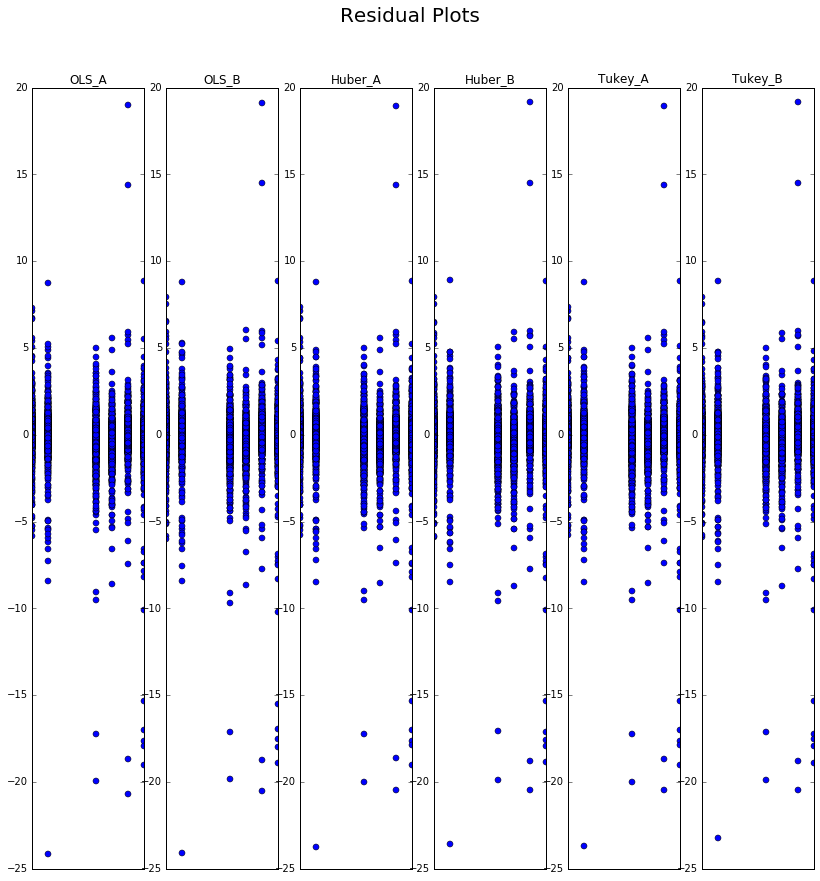

In [34]:
#################
# performance 2 #
#################

resids_OLS_A = pd.DataFrame()
resids_OLS_B = pd.DataFrame()
resids_Huber_A = pd.DataFrame()
resids_Huber_B = pd.DataFrame()
resids_Tukey_A = pd.DataFrame()
resids_Tukey_B = pd.DataFrame()
for key in rets:
    resids_OLS_A = pd.concat((resids_OLS_A,pd.DataFrame(resid_OLS_A[key]/Vol_OLS_A[key])),axis=0)
    resids_OLS_B = pd.concat((resids_OLS_B,pd.DataFrame(resid_OLS_B[key]/Vol_OLS_B[key])),axis=0)
    resids_Huber_A = pd.concat((resids_Huber_A,pd.DataFrame(resid_Huber_A[key]/Vol_Huber_A[key])),axis=0)
    resids_Huber_B = pd.concat((resids_Huber_B,pd.DataFrame(resid_Huber_B[key]/Vol_Huber_B[key])),axis=0)
    resids_Tukey_A = pd.concat((resids_Tukey_A,pd.DataFrame(resid_Tukey_A[key]/Vol_Tukey_A[key])),axis=0)
    resids_Tukey_B = pd.concat((resids_Tukey_B,pd.DataFrame(resid_Tukey_B[key]/Vol_Tukey_B[key])),axis=0)

#resids plot
plt.figure(figsize=(14,14))
plt.suptitle('Residual Plots',fontsize=20)
x1 = plt.subplot(161)
plt.title('OLS_A')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_OLS_A.index,resids_OLS_A,'o')
x1 = plt.subplot(162)
plt.title('OLS_B')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_OLS_B.index,resids_OLS_B,'o')
plt.xlabel('')
x1 = plt.subplot(163)
plt.title('Huber_A')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_Huber_A.index,resids_Huber_A,'o')
plt.xlabel('')
x1 = plt.subplot(164)
plt.title('Huber_B')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_Huber_B.index,resids_Huber_B,'o')
plt.xlabel('')
x1 = plt.subplot(165)
plt.title('Tukey_A')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_Tukey_A.index,resids_Tukey_A,'o')
plt.xlabel('')
x1 = plt.subplot(166)
plt.title('Tukey_B')
x1.axes.get_xaxis().set_visible(False)
plt.plot(resids_Tukey_B.index,resids_Tukey_B,'o')
plt.xlabel('')

**The above plot is very similar to the previous non-normalized ```Residuals Plot```.**

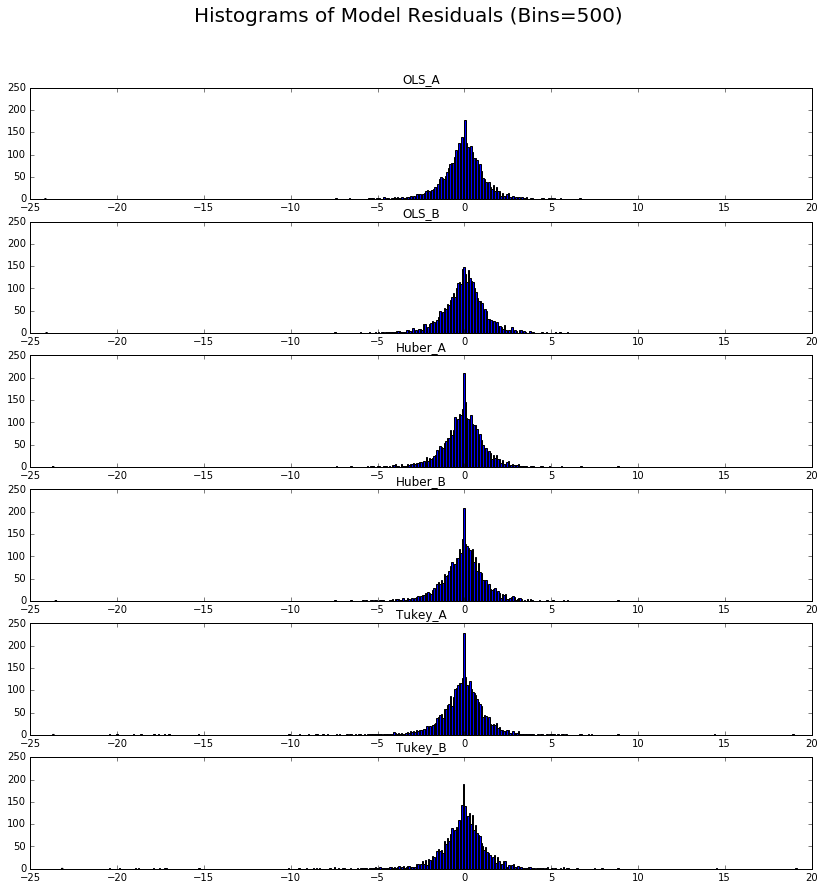

In [35]:
#histograms
plt.figure(figsize=(14,14))
plt.suptitle('Histograms of Model Residuals (Bins=500)',fontsize=20)
x1 = plt.subplot(611)
x1.set_ylim([0,250])
plt.title('OLS_A')
hist1 = plt.hist(np.array(resids_OLS_A),500)
x1 = plt.subplot(612)
x1.set_ylim([0,250])
plt.title('OLS_B')
hist2 = plt.hist(np.array(resids_OLS_B),500)
x1 = plt.subplot(613)
x1.set_ylim([0,250])
plt.title('Huber_A')
hist3 = plt.hist(np.array(resids_Huber_A),500)
x1 = plt.subplot(614)
x1.set_ylim([0,250])
plt.title('Huber_B')
hist4 = plt.hist(np.array(resids_Huber_B),500)
x1 = plt.subplot(615)
x1.set_ylim([0,250])
plt.title('Tukey_A')
hist5 = plt.hist(np.array(resids_Tukey_A),500)
x1 = plt.subplot(616)
x1.set_ylim([0,250])
plt.title('Tukey_B')
hist6 = plt.hist(np.array(resids_Tukey_B),500)
plt.show()

**The above histograms are somewhat interesting.  Normalizing the residuals disagrees the observation in the previous histograms plot; that the robust regressions are slightly more heavy tailed.  The robust regressions have a higher frequency of normalized residuals at zero, suggesting a better fit.**

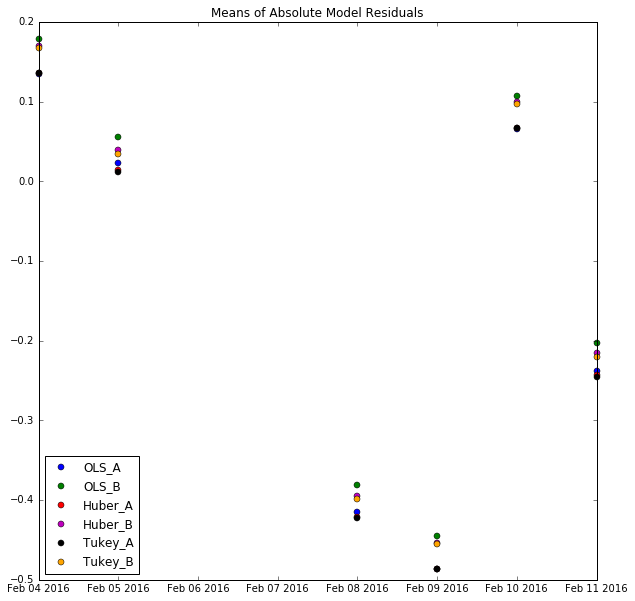

In [36]:
#means by day
means_OLS_A = resids_OLS_A.groupby(resids_OLS_A.index).mean()
means_OLS_B = resids_OLS_B.groupby(resids_OLS_B.index).mean()
means_Huber_A = resids_Huber_A.groupby(resids_Huber_A.index).mean()
means_Huber_B = resids_Huber_B.groupby(resids_Huber_B.index).mean()
means_Tukey_A = resids_Tukey_A.groupby(resids_Tukey_A.index).mean()
means_Tukey_B = resids_Tukey_B.groupby(resids_Tukey_B.index).mean()
plt.figure(figsize=(10,10))
plt.plot(means_OLS_A.index,means_OLS_A,'o',clip_on=False)
plt.plot(means_OLS_B.index,means_OLS_B,'go',clip_on=False)
plt.plot(means_Huber_A.index,means_Huber_A,'ro',clip_on=False)
plt.plot(means_Huber_B.index,means_Huber_B,'mo',clip_on=False)
plt.plot(means_Tukey_A.index,means_Tukey_A,'o',color='black',clip_on=False)
plt.plot(means_Tukey_B.index,means_Tukey_B,'o',color='orange',clip_on=False)
plt.title('Means of Absolute Model Residuals')
plt.legend(['OLS_A','OLS_B','Huber_A','Huber_B','Tukey_A','Tukey_B'],loc='best',numpoints=1)
plt.show()

**The observation here is the same as in the previous plot of means for non-normalized residuals.**

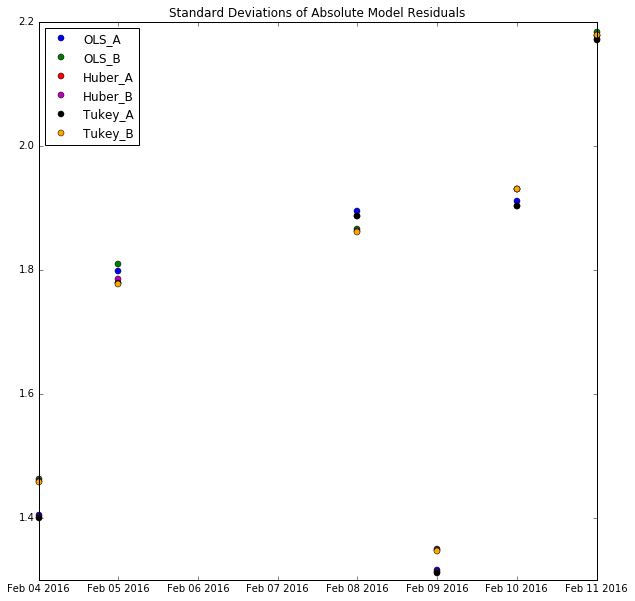

In [37]:
#stdev by day
std_OLS_A = resids_OLS_A.groupby(resids_OLS_A.index).std()
std_OLS_B = resids_OLS_B.groupby(resids_OLS_B.index).std()
std_Huber_A = resids_Huber_A.groupby(resids_Huber_A.index).std()
std_Huber_B = resids_Huber_B.groupby(resids_Huber_B.index).std()
std_Tukey_A = resids_Tukey_A.groupby(resids_Tukey_A.index).std()
std_Tukey_B = resids_Tukey_B.groupby(resids_Tukey_B.index).std()
plt.figure(figsize=(10,10))
plt.plot(means_OLS_A.index,std_OLS_A,'o',clip_on=False)
plt.plot(means_OLS_B.index,std_OLS_B,'go',clip_on=False)
plt.plot(means_Huber_A.index,std_Huber_A,'ro',clip_on=False)
plt.plot(means_Huber_B.index,std_Huber_B,'mo',clip_on=False)
plt.plot(means_Tukey_A.index,std_Tukey_A,'o',color='black',clip_on=False)
plt.plot(means_Tukey_B.index,std_Tukey_B,'o',color='orange',clip_on=False)
plt.title('Standard Deviations of Absolute Model Residuals')
plt.legend(['OLS_A','OLS_B','Huber_A','Huber_B','Tukey_A','Tukey_B'],loc='best',numpoints=1)
plt.show()

**It is interesting here that the standard deviations of model residuals are upward sloping on average over time.  This makes intuitive sense, as the model should naturally become less accurate over time.  Again though, a longer time horizon of out of sample residuals to test would be good.**

In [24]:
#overall t stat
t_OLS_A = resids_OLS_A.mean()[0]/resids_OLS_A.std()[0]
t_OLS_B = resids_OLS_B.mean()[0]/resids_OLS_B.std()[0]
t_Huber_A = resids_Huber_A.mean()[0]/resids_Huber_A.std()[0]
t_Huber_B = resids_Huber_B.mean()[0]/resids_Huber_B.std()[0]
t_Tukey_A = resids_Tukey_A.mean()[0]/resids_Tukey_A.std()[0]
t_Tukey_B = resids_Tukey_B.mean()[0]/resids_Tukey_B.std()[0]
print('t-stat of OLS_A: {}'.format(t_OLS_A))
print('t-stat of OLS_B: {}'.format(t_OLS_B))
print('t-stat of Huber_A: {}'.format(t_Huber_A))
print('t-stat of Huber_B: {}'.format(t_Huber_B))
print('t-stat of Tukey_A: {}'.format(t_Tukey_A))
print('t-stat of Tukey_B: {}'.format(t_Tukey_B))

t-stat of OLS_A: -0.08531663573853202
t-stat of OLS_B: -0.06359531743358349
t-stat of Huber_A: -0.08725894910572986
t-stat of Huber_B: -0.07017673917533587
t-stat of Tukey_A: -0.08791071806024801
t-stat of Tukey_B: -0.07205558228498533


**Again, the t-tests of the normalized residuals suggest the model means do not deviate from zero at the 95% significance level.  Since they are roughly the same regardless of the intercept, intuitively it would make more sense to use a model that has no intercept (i.e. goes through the origin).** 

In [21]:
#extreme data
abs(resids_OLS_A).max()
abs(resids_OLS_B).max()
abs(resids_Huber_A).max()
abs(resids_Huber_B).max()
abs(resids_Tukey_A).max()
abs(resids_Tukey_B).max()
print('Largest Absolute Residual of OLS_A: {}'.format((abs(resids_OLS_A).max()[0]-resids_OLS_A.mean()[0])/resids_OLS_A.std()[0]))
print('Largest Absolute Residual of OLS_B: {}'.format((abs(resids_OLS_B).max()[0]-resids_OLS_B.mean()[0])/resids_OLS_B.std()[0]))
print('Largest Absolute Residual of Huber_A: {}'.format((abs(resids_Huber_A).max()[0]-resids_Huber_A.mean()[0])/resids_Huber_A.std()[0]))
print('Largest Absolute Residual of Huber_B: {}'.format((abs(resids_Huber_B).max()[0]-resids_Huber_B.mean()[0])/resids_Huber_B.std()[0]))
print('Largest Absolute Residual of Tukey_A: {}'.format((abs(resids_Tukey_A).max()[0]-resids_Tukey_A.mean()[0])/resids_Tukey_A.std()[0]))
print('Largest Absolute Residual of Tukey_B: {}'.format((abs(resids_Tukey_B).max()[0]-resids_Tukey_B.mean()[0])/resids_Tukey_B.std()[0]))

Largest Absolute Residual of OLS_A: 13.587163413106861
Largest Absolute Residual of OLS_B: 13.422203252630021
Largest Absolute Residual of Huber_A: 13.39170958468075
Largest Absolute Residual of Huber_B: 13.178856850823822
Largest Absolute Residual of Tukey_A: 13.392644021265106
Largest Absolute Residual of Tukey_B: 12.989775080417193


**As before, the largest outliers of each model are quite similar.**


**In all, regardless of the model and regardless of setting the intercept at zero, the models appear to perform in a similar fashion.  This suggests that assumptions of gaussian returns holds quite true for the data analyzed.  Further testing using a different independent variable, or different equities, may be worth investigating.  Choosing a model (especially in this case, because there is hardly any statistical difference) should make intuitive sense, and match the context of the data.  The data for this assignment has overall been benign, so both OLS, Huber and Tukey work well.**